In [ ]:
import os
import pydicom
import numpy as np
import pywt
import matplotlib.pyplot as plt

def read_dicom_files(directory):
    dicom_files = []
    for filename in os.listdir(directory):
        if filename.endswith(".dcm"):
            filepath = os.path.join(directory, filename)
            dicom_files.append(pydicom.dcmread(filepath).pixel_array)
    return np.array(dicom_files)

def perform_2d_wavelet_transform1(data, wavelet = 'db2'):
    coeffs = pywt.dwtn(data, wavelet=wavelet, mode = 'periodization')
    return coeffs

def perform_3d_wavelet_transform_pywt(data, wavelet = 'db2'):
    coeffs = pywt.dwtn(data, wavelet=wavelet, mode = 'periodization')
    return coeffs

def normalize(data):
    data = np.abs(data)
    data = data / np.max(data)
    return data

def display_images(data, title, transform_type):
    if transform_type == '3D':
        fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # 2x4 grid
        keys = ['LLL', 'LLH', 'LHL', 'LHH', 'HLL', 'HLH', 'HHL', 'HHH']  
        labels = {'LLL': 'LLL', 'LLH': 'LLH', 'LHL': 'LHL', 'LHH': 'LHH', 
                  'HLL': 'HLL', 'HLH': 'HLH', 'HHL': 'HHL', 'HHH': 'HHH'}
        for i, key in enumerate(keys):
            row, col = divmod(i, 4)
            if key in data:
                value = data[key]
                if value.ndim == 3:
                    value = value[0]  # Select the first slice if 3D
                value = normalize(value)  # Normalize the data
                axes[row, col].imshow(value, cmap='gray')
                axes[row, col].set_title(f'{title} - {labels[key]}')
                axes[row, col].axis('off')
            else:
                axes[row, col].axis('off')  # Hide the axis if key is missing
    elif transform_type == '2D':
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))  # 1x4 grid
        keys = ['LL', 'LH', 'HL', 'HH']  # Explicit order
        labels = {'LL': 'LL', 'LH': 'LH', 'HL': 'HL', 'HH': 'HH'}
        for i, key in enumerate(keys):
            value = data[key]
            value = normalize(value)  # Normalize the data
            axes[i].imshow(value, cmap='gray')
            axes[i].set_title(f'{title} - {labels[key]}')
            axes[i].axis('off')
    plt.tight_layout()
    plt.show()
    
# Directory containing the DICOM files
dicom_directory = 'Test_Sets/CT/3/DICOM_anon/'

# Read DICOM files
dicom_data = read_dicom_files(dicom_directory)



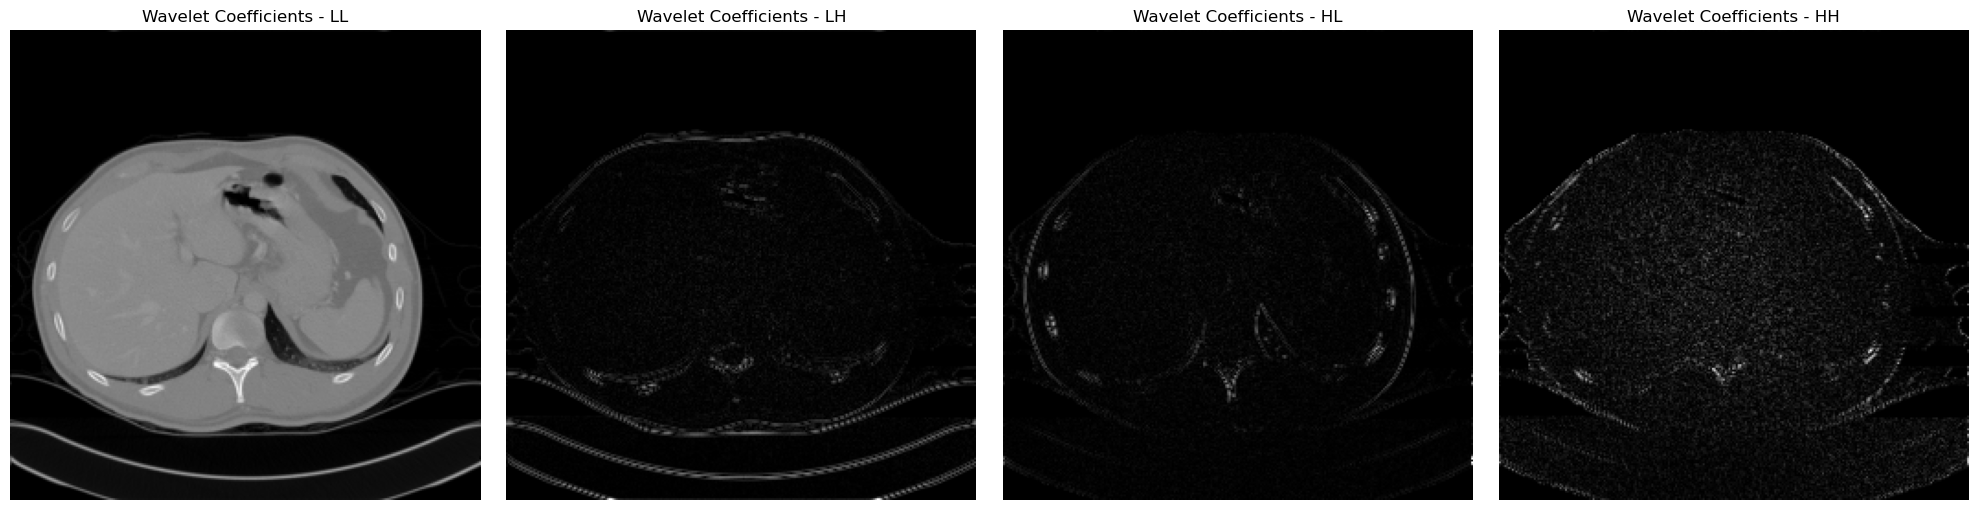

Subband LL resolution: (256, 256)
Subband LH resolution: (256, 256)
Subband HL resolution: (256, 256)
Subband HH resolution: (256, 256)


In [30]:
# Perform 2D wavelet transform
wavelet_coeffs_2d = perform_2d_wavelet_transform1(dicom_data[0])  # Use the first slice for 2D transform
display_images({'LL': wavelet_coeffs_2d[0], 'LH': wavelet_coeffs_2d[1][0], 'HL': wavelet_coeffs_2d[1][1], 'HH': wavelet_coeffs_2d[1][2]}, 'Wavelet Coefficients', '2D')

# Print resolution of each subband
subbands = {'LL': wavelet_coeffs_2d[0], 'LH': wavelet_coeffs_2d[1][0], 'HL': wavelet_coeffs_2d[1][1], 'HH': wavelet_coeffs_2d[1][2]}
for key, coeff in subbands.items():
    print(f"Subband {key} resolution: {coeff.shape}")

Original DICOM image resolution: (512, 512)
Intermediate cA shape: (256, 512), max value: 3047.757992690764
Intermediate cD shape: (256, 512), max value: 689.510111913605
Intermediate cA shape: (256, 256), max value: 4253.769686450205
Intermediate cD shape: (256, 256), max value: 990.1523537585721
Intermediate cA shape: (256, 256), max value: 954.2327690848435
Intermediate cD shape: (256, 256), max value: 170.95246330471932
Shape of LL subband from custom implementation: (256, 256)
Shape of LL subband from PyWavelets: (256, 256)
Shape of LH subband from custom implementation: (256, 256)
Shape of LH subband from PyWavelets: (256, 256)
Shape of HL subband from custom implementation: (256, 256)
Shape of HL subband from PyWavelets: (256, 256)
Shape of HH subband from custom implementation: (256, 256)
Shape of HH subband from PyWavelets: (256, 256)
Max value of LL subband from custom implementation: 4253.769686450205
Max value of LL subband from PyWavelets: 4253.769686450205
Max value of LH

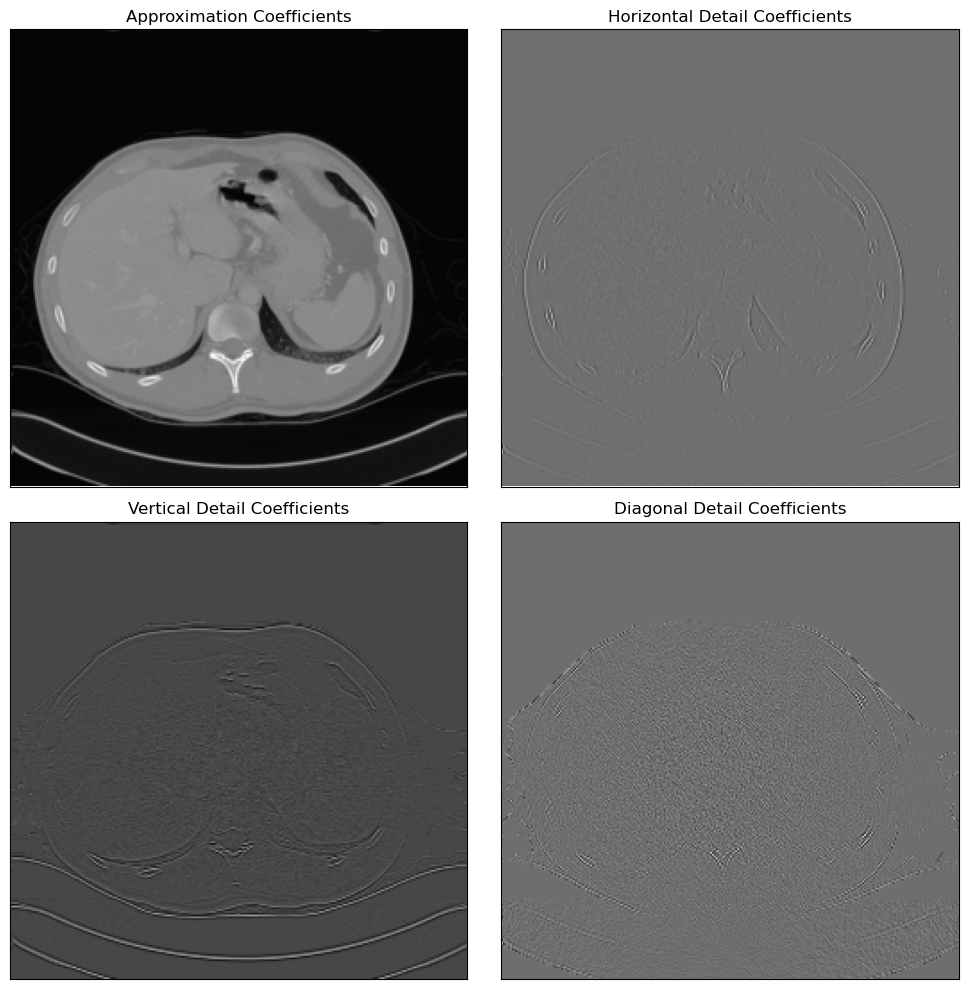

In [69]:
import os
import numpy as np
import pydicom
import matplotlib.pyplot as plt

def read_dicom_files(directory):
    dicom_files = []
    for filename in os.listdir(directory):
        if filename.endswith(".dcm"):
            filepath = os.path.join(directory, filename)
            dicom_files.append(pydicom.dcmread(filepath).pixel_array)
    return np.array(dicom_files)

# Function to perform 1D convolution
def convolve_1d(data, filter, mode='symmetric'):
    """Perform 1D convolution with the given filter and boundary handling."""
    filter_len = len(filter)
    data_len = len(data)
    pad_width = filter_len // 2

    if mode == 'symmetric':
        data = np.pad(data, pad_width, mode='symmetric')
    elif mode == 'periodic':
        data = np.pad(data, pad_width, mode='wrap')
    elif mode == 'constant':
        data = np.pad(data, pad_width, mode='constant')
    else:
        raise ValueError(f"Unsupported mode: {mode}")

    result_len = data_len + 2 * pad_width
    result = np.zeros(result_len)
    
    for i in range(result_len):
        for j in range(filter_len):
            if 0 <= i - j < len(data):
                result[i] += data[i - j] * filter[j]
    
    # Trim the result to match the original data length
    result = result[pad_width:-pad_width]
    
    return result

def downsample(data):
    """Downsample the data by taking every second element."""
    return data[::2]

def dwt_axis(data, dec_lo, dec_hi, axis, mode='periodic'):
    """Perform single-level discrete wavelet transform along a specified axis."""
    # Move the specified axis to the front
    data = np.moveaxis(data, axis, 0)
    
    # Perform convolution and downsampling along the first axis
    cA = np.apply_along_axis(lambda x: downsample(convolve_1d(x, dec_lo, mode)), 0, data)
    cD = np.apply_along_axis(lambda x: downsample(convolve_1d(x, dec_hi, mode)), 0, data)
    
    # Print intermediate results for debugging
    print(f"Intermediate cA shape: {cA.shape}, max value: {np.max(cA)}")
    print(f"Intermediate cD shape: {cD.shape}, max value: {np.max(cD)}")
    
    # Move the axis back to its original position
    cA = np.moveaxis(cA, 0, axis)
    cD = np.moveaxis(cD, 0, axis)
    
    return cA, cD

def dwtn(data, wavelet, mode='periodic', axes=None):

    data = np.asarray(data)
    if data.dtype == np.dtype('object'):
        raise TypeError("Input must be a numeric array-like")
    if data.ndim < 1:
        raise ValueError("Input data must be at least 1D")

    if axes is None:
        axes = range(data.ndim)
    axes = [a + data.ndim if a < 0 else a for a in axes]

    # Define Daubechies 2 (db2) wavelet filters
    dec_lo = [-0.12940952255126037, 0.2241438680420134, 0.8365163037378079, 0.48296291314453416]
    dec_hi = [-0.48296291314453416, 0.8365163037378079, -0.2241438680420134, -0.12940952255126037]

    coeffs = [('', data)]
    for axis in axes:
        new_coeffs = []
        for subband, x in coeffs:
            cA, cD = dwt_axis(x, dec_lo, dec_hi, axis, mode)
            new_coeffs.extend([(subband + 'a', cA),
                               (subband + 'd', cD)])
        coeffs = new_coeffs
    return dict(coeffs)

# Directory containing the DICOM files
dicom_directory = 'Test_Sets/CT/3/DICOM_anon/'

# Read DICOM files
dicom_images = read_dicom_files(dicom_directory)

# Apply wavelet transform to the first DICOM image
image = dicom_images[0]

# Print the resolution of the original DICOM image
print(f"Original DICOM image resolution: {image.shape}")

# Perform wavelet transform using the custom implementation
coeffs_custom = dwtn(image, 'db2')

# Assuming perform_2d_wavelet_transform1 and display_images functions are defined
wavelet_coeffs_2d = perform_2d_wavelet_transform1(image)  # Use the first slice for 2D transform

# Compare subbands from each implementation
subbands_1 = {'LL': coeffs_custom['aa'], 'LH': coeffs_custom['ad'], 'HL': coeffs_custom['da'], 'HH': coeffs_custom['dd']}
subbands_2 = {'LL': wavelet_coeffs_2d[0], 'LH': wavelet_coeffs_2d[1][0], 'HL': wavelet_coeffs_2d[1][1], 'HH': wavelet_coeffs_2d[1][2]}

# Print shapes of subbands for debugging
for key in subbands_1:
    print(f"Shape of {key} subband from custom implementation: {subbands_1[key].shape}")
    print(f"Shape of {key} subband from PyWavelets: {subbands_2[key].shape}")

# Compare intermediate results 
for key in subbands_1:
    print(f"Max value of {key} subband from custom implementation: {np.max(subbands_1[key])}")
    print(f"Max value of {key} subband from PyWavelets: {np.max(subbands_2[key])}")

# Calculate MSE for each subband
for key in subbands_1:
    if subbands_1[key].shape != subbands_2[key].shape:
        subbands_1[key] = subbands_2[key], subbands_1[key]
        subbands_2[key] = subbands_1[key], subbands_2[key]
    mse = np.mean((subbands_1[key] - subbands_2[key]) ** 2)
    print(f"MSE for {key} subband: {mse}")

# Display subbands
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes[0, 0].imshow(subbands_1['LL'], cmap='gray')
axes[0, 0].set_title('Approximation Coefficients')
axes[0, 1].imshow(subbands_1['LH'], cmap='gray')
axes[0, 1].set_title('Horizontal Detail Coefficients')
axes[1, 0].imshow(subbands_1['HL'], cmap='gray')
axes[1, 0].set_title('Vertical Detail Coefficients')
axes[1, 1].imshow(subbands_1['HH'], cmap='gray')
axes[1, 1].set_title('Diagonal Detail Coefficients')

for ax in axes.flat:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

Shape of coefs_numpy: (1, 4, 1, 513, 513)
Shape of LL subband from PyTorch implementation: (513, 513)
Shape of LH subband from PyTorch implementation: (513, 513)
Shape of HL subband from PyTorch implementation: (513, 513)
Shape of HH subband from PyTorch implementation: (513, 513)


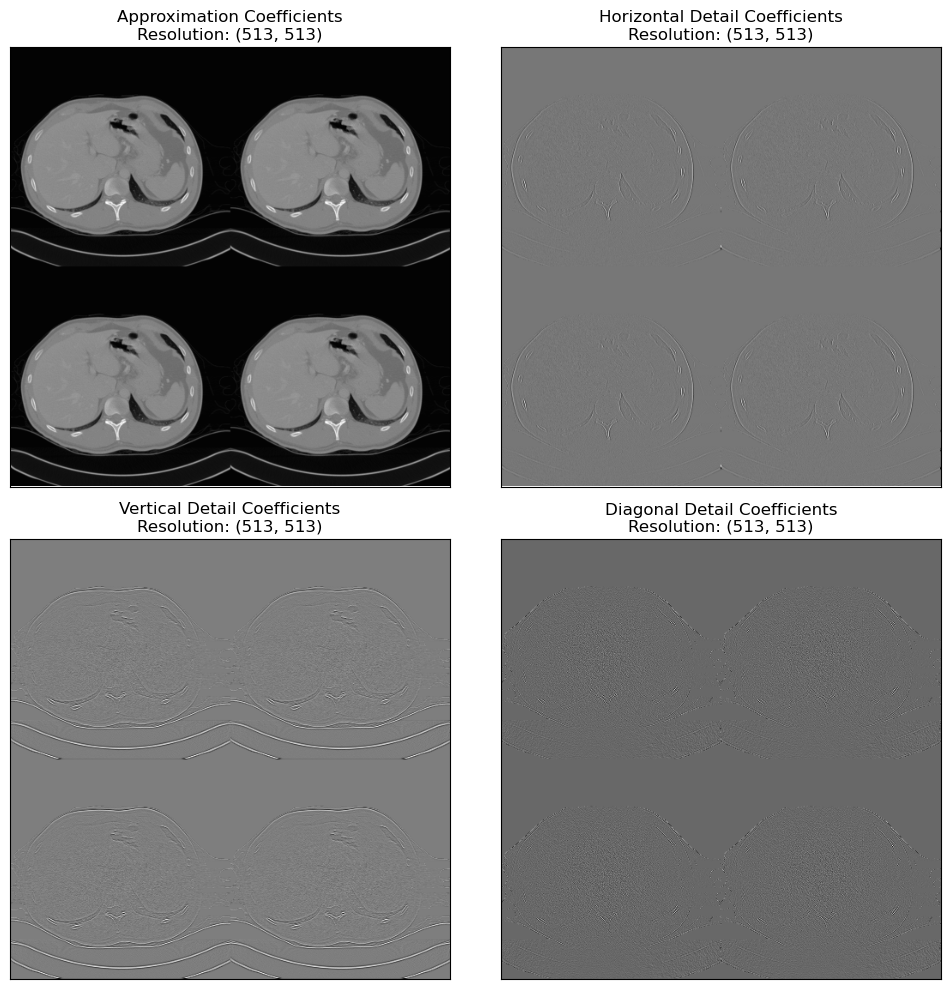

In [208]:
import numpy as np
import pywt

def convolve(data, is_low_pass):
    wavelet = pywt.Wavelet('db2')
    if is_low_pass:
        filter_coeffs = wavelet.dec_lo
    else:
        filter_coeffs = wavelet.dec_hi

    # Perform convolution with the filter coefficients
    conv_result = np.convolve(data, filter_coeffs[::-1], mode='same')

    # Handle boundary conditions for periodization
    conv_result = np.roll(conv_result, -len(filter_coeffs) // 2)

    # Downsample the result
    result = conv_result[::2]  # Downsample by taking every second element starting from index 0

    return result

# Test data
data = np.random.rand(16)

# Convolve using custom function
custom_low_pass = convolve(data, True)
custom_high_pass = convolve(data, False)

# Convolve using pywavelets
wavelet = pywt.Wavelet('db2')
pywt_low_pass, pywt_high_pass = pywt.dwt(data, wavelet, mode='periodization')

# Compare results
print("Custom Low Pass:", custom_low_pass)
print("PyWavelets Low Pass:", pywt_low_pass)
print("Custom High Pass:", custom_high_pass)
print("PyWavelets High Pass:", pywt_high_pass)

# Calculate Mean Squared Error
mse_low_pass = np.mean((custom_low_pass - pywt_low_pass) ** 2)
mse_high_pass = np.mean((custom_high_pass - pywt_high_pass) ** 2)

print("MSE Low Pass:", mse_low_pass)
print("MSE High Pass:", mse_high_pass)

Custom Low Pass: [0.48335686 0.86014596 0.91357218 0.9977813  0.95424571 0.31118841
 0.34090554 0.6515966 ]
PyWavelets Low Pass: [0.86226335 0.33779766 0.82439754 0.92575477 0.91667759 1.05660324
 0.523065   0.17533052]
Custom High Pass: [-0.48600347  0.30804408  0.13780037 -0.0572652   0.33027748  0.38519803
  0.03638814 -0.17459478]
PyWavelets High Pass: [-0.32706056  0.33800006  0.07568236 -0.00309259  0.37481355  0.38507708
  0.01140371  0.03217708]
MSE Low Pass: 0.1558279840115236
MSE High Pass: 0.009789478393078876
